# **Advanced Data Analytics Capstone: Classifying TikTok videos using machine learning**

**Objective**: The primary aim of this project centers on mitigating misinformation within TikTok videos.

**Goal**: The goal is to differentiate between TikTok videos that present factual "claims" and those that express subjective "opinions".

Project Breakdown according with the PACE stages:

Segment 1: Ethical considerations

    Assessing the ethical implications associated with the project's objectives.
    Considering potential adjustments to align with ethical standards.

Segment 2: Feature engineering

    Engaging in feature manipulation encompassing selection, extraction, and transformation to prepare the dataset for subsequent modeling stages.

Segment 3: Modeling

    Constructing predictive models followed by an evaluation to inform future steps and decisions.


## **Planning**

**1. What are we being asked to do?**

**Business need and modeling objective**

TikTok users report videos they believe breach the platform's terms of service, but the volume is too large for human moderation. Analysis suggests that violating videos often present claims rather than opinions. Therefore, TikTok aims to create a model to distinguish between claims and opinions. Videos labeled as opinions will be less likely to undergo human review, while those labeled as claims will undergo further sorting, potentially prioritizing them for human review based on factors such as the number of reports. Implementing a machine learning model would streamline the process of identifying videos most likely violating TikTok's terms of service for human moderators.

A machine learning model would greatly assist in the effort to present human moderators with videos that are most likely to be in violation of TikTok's terms of service.

**Modeling design and target variable**

The data dictionary reveals a column named `claim_status`, which will serve as our target variable, because it indactes whether a video is classified as a claim or an opinion. In essence, the model's objective is to predict, for each video, whether it falls into the category of a claim or an opinion. 
Given that the model is predicting a binary class, this task is categorized as a classification task.

**Selecting an evaluation metric**

To determine the best evaluation metric to be used, let's review the posible cases of failure:

  - **False positives:** The model predicts a video is a claim when in fact it is an opinion
  - **False negatives:** The model predicts a video is an opinion when in fact it is a claim

**2. What are the ethical implications of building the model?**

In this context, prioritizing false positives over false negatives is preferable for the model. It's critical to accurately identify videos that breach the terms of service, even if it results in misclassifying some opinion videos as claims. The consequence of misclassifying an opinion as a claim is that the video undergoes human review, which is acceptable. However, misclassifying a claim as an opinion could lead to the video not being reviewed at all, potentially allowing it to violate the terms of service. According to the data dictionary, a video violating the terms of service would be attributed to a "banned" author. Thus, ensuring the detection of violating videos is paramount, even if it means some opinion videos are incorrectly classified as claims.

Because it's more important to minimize **false negatives**, the model evaluation metric will be **recall**.

**3. How should we proceed?**

**Modeling workflow and model selection process**

Previous analysis of the data indicates a sample size of approximately 20,000 videos, which is deemed adequate for executing a model validation process.

The validation workflow will be structured into the following steps:
1. Split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set (grid search)
3. Perform final model selection on the validation set
4. Assess the best model's performance on the test set

### **Imports and data loading**

In [176]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# ML models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [177]:
# Loading dataset into dataframe
df = pd.read_csv("tiktok.csv")

## **Analysis**

### **Data examination, summary info, and descriptive stats**

Let's inspect the data we are working on:

In [178]:
# Displaying first few rows
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [179]:
# Getting number of rows and columns
df.shape

(19382, 12)

In [180]:
# Getting basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [181]:
# Generating basic descriptive stats
df.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [182]:
# Check for missing values
df.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

**Given the dataset's ample size in relation to the scarcity of missing values, it's viable to drop entries containing missing values.

In [183]:
# Drop rows with missing values
df = df.dropna(axis=0)

In [184]:
# Check for duplicates
df.duplicated().sum()

0

In [185]:
# Check class balance
df["claim_status"].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

Regarding data outliers, since we are using tree based models, which are robust to outliers, we dont need to check for them.

**Approximately 50.3% of the dataset represents claims and 49.7% represents opinions, so the outcome variable is balanced.**

## **Constructing**

### **Feature engineering** 

In [186]:
# Extract the length of each `video_transcription_text` entry and place them into new column`text_length` so that it can be used by the model.
df['text_length'] = df['video_transcription_text'].str.len()
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


In [187]:
# Calculate the average `text_length` for claims and opinions.
df[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


### **Visualization** 

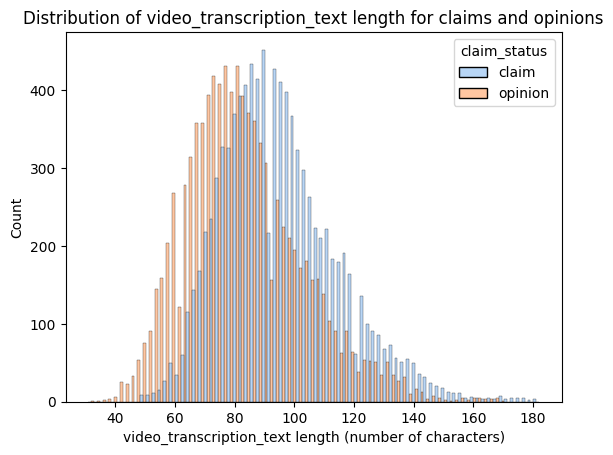

In [188]:
# Histogram of the distribution of `text_length` for claims and opinions
sns.histplot(data=df, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()


The distributions of letter counts for both claims and opinions exhibit a nearly normal shape with a slight rightward skew. Notably, claim videos typically contain more characters, with an average difference of approximately 13 characters, as previously noted.

### **Feature selection and transformation**

In [189]:
# Encoding target and categorical variables.

X = df.copy()
# Drop unnecessary columns
X = X.drop(['#', 'video_id'], axis=1)
# Encode target variable
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})
# Dummy encode remaining categorical values
X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)
X.head()

/tmp/ipykernel_96795/223053137.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})


,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


### **Splitting the data**

In [190]:
# Our target variable is the binary 'claim_status', with 0 for an opinion and 1 for a claim
# Isolate target variable
y = X['claim_status']

Isolate the features.

In [191]:
# Isolate features
X = X.drop(['claim_status'], axis=1)

# Display first few rows of features dataframe
X.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


#### **Creating train/validate/test sets**

In [192]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

# Get shape of each training, validation, and testing set to confirm they are aligned
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 11), (3817, 11), (3817, 11), (11450,), (3817,), (3817,))

**Notes**
- The number of features (`11`) aligns between the training and testing sets.
- The number of rows aligns between the features and the outcome variable for training (`11,450`) and both validation and testing data (`3,817`).

In [193]:
# Tokenizing(NLP): Here we break each video's transcription text into both 2-grams and 3-grams, then take the 15 most frequently occurring tokens from the entire dataset to use as features.
# Set up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')

Fit the vectorizer to the training data (generate the n-grams) and transform it (tally the occurrences). Only fit to the training data, not the validation or test data.

In [194]:
# Extract numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [195]:
# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

# Display first few rows
count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [196]:
# Concatenate `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_train after dropping `video_transcription_text`,
# so that the indices align with those in `X_train` and `count_df`
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

# Display first few rows
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,134,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,97,False,True,False,...,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,76,False,False,True,...,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,58,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,57,False,False,False,...,0,0,0,0,0,0,0,0,0,0


Get n-gram counts for the validation data. Notice that the vectorizer is not being refit to the validation data. It's only transforming it. In other words, the transcriptions of the videos in the validation data are only being checked against the n-grams found in the training data.

In [197]:
# Extract numerical features from `video_transcription_text` in the testing set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [198]:
# Place the numerical representation of `video_transcription_text` from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [199]:
# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_val after dropping `video_transcription_text`,
# so that the indices align with those in `validation_count_df`
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)

# Display first few rows
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,72,False,False,True,...,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,96,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,88,False,False,False,...,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.0,1230.0,564.0,248.0,83,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,104,False,False,True,...,0,0,0,0,0,0,0,1,0,0


Repeat the process to get n-gram counts for the test data. Again, don't refit the vectorizer to the test data. Just transform it.

In [200]:
# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,107,False,False,False,...,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,69,True,False,True,...,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,90,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.0,847.0,17.0,5.0,76,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.0,15348.0,252.0,91.0,72,False,False,False,...,0,0,0,0,0,0,0,0,0,0


### **Building models**

### **1. Random Forest Classifier**


Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [201]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Creating a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Dictionary of scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiating a GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

Note this cell might take several minutes to run.

In [202]:
%%time
rf_cv.fit(X_train_final, y_train)

CPU times: user 3min 57s, sys: 172 ms, total: 3min 57s
Wall time: 3min 57s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [203]:
# Get the best recall score
rf_cv.best_score_

0.9948228253467271

In [204]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

The model demonstrates exceptional performance, boasting an average recall score of 0.995 across the five cross-validation folds. To ensure the model's precision and avoid misclassification of all samples as claims, the precision score is scrutinized. Confirming that the model's classifications are not overly biased, it becomes evident that the model achieves near-perfect classification.

### **2. XGBoost**

In [205]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [206]:
%%time
xgb_cv.fit(X_train_final, y_train)

CPU times: user 1h 17min 18s, sys: 7.8 s, total: 1h 17min 26s
Wall time: 5min 34s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [207]:
xgb_cv.best_score_

0.9898176171763818

In [208]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

This model also exhibits exceptional performance. While its recall score is marginally lower than that of the random forest model, its precision score is flawless.


## **Executing**

Now we will evaluate our models against the validation data.

### **1. Random forest**

In [209]:
# Use the random forest "best estimator" model to get predictions on the validation set and display them
y_pred = rf_cv.best_estimator_.predict(X_val_final)
y_pred

array([1, 0, 1, ..., 1, 1, 1])

In [210]:
# True labels of the validation set
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

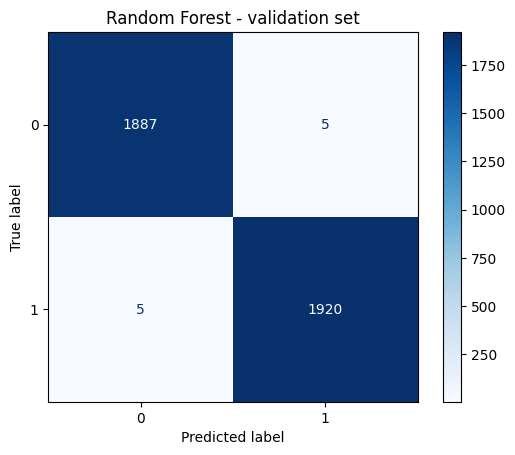

In [211]:
# Creating a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot(cmap="Blues")
plt.title('Random Forest - validation set');
plt.show()

**As depicted in the above confusion matrix, this model generates very low false negatives(lower-left quadrant).**

#### **Classification report**

In [212]:
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



The classification report above reveals that the random forest model achieved nearly perfect scores. However, the confusion matrix indicates 10 misclassifications, comprising five false positives and five false negatives.

### **2. XGBoost**

In [213]:
#Evaluating XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val_final)
y_pred

array([1, 0, 1, ..., 1, 1, 1])

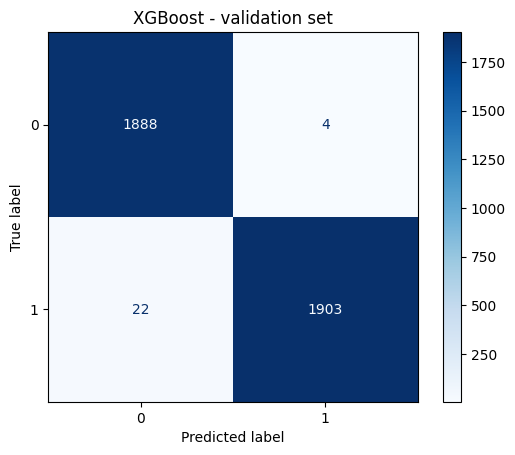

In [214]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)


# Display plot
log_disp.plot(cmap="Blues")
plt.title('XGBoost - validation set');
plt.show()


In [215]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



The XGBoost model also demonstrated near-perfect results. However, its errors predominantly consisted of false negatives. Given that identifying claims was major importance, ensuring the model effectively captures all actual claim videos was a priority. The random forest classifier had a superior recall score thus becoming our chosen model.

### **Use chosen model to predict on test data**

In [216]:
# Use chosen model to predict on test data
y_pred = rf_cv.best_estimator_.predict(X_test_final)

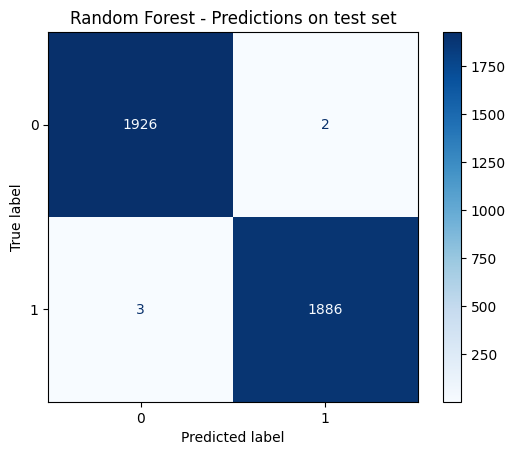

In [220]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot(cmap="Blues")

# Display plot
plt.title('Random Forest - Predictions on test set');
plt.show()

#### **Feature importances of chosen model**



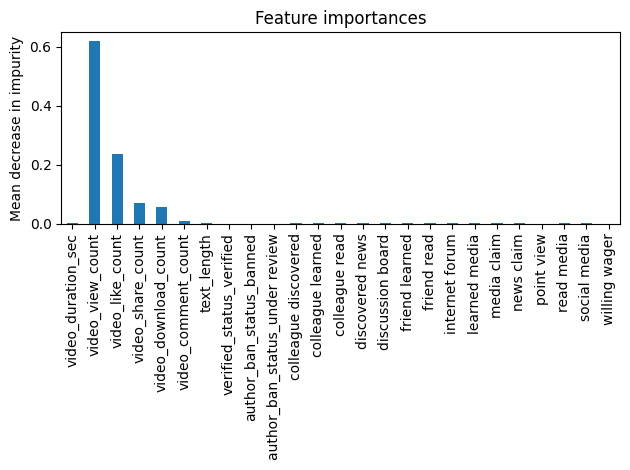

In [218]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

As we can see the most predictive features primarily revolved around the engagement levels. This outcome were expectated, as previous exploratory data analysis (EDA) had already hinted at this correlation.

## Conclusions

1. This model is recommended due to its strong performance on both validation and test holdout data. Consistently high precision and F<sub>1</sub> scores indicate successful classification of claims and opinions.
2. The model's predictive power predominantly comes from features related to user engagement levels, encompassing views, likes, shares, and downloads associated with each video.
3. Given the current model's near-perfect performance, there's no immediate necessity for feature engineering.
4. While the current model doesn't require additional features, integrating the number of times a video was reported and the total user reports for all videos posted by each author would enhance its utility and effectiveness.